In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import sys
import pickle
from scipy.ndimage import gaussian_filter1d

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
print(device, dtype)

from codebase import *

import warnings
warnings.filterwarnings("ignore")

/home/dobrik/anaconda3/envs/narti-recode/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda torch.float32
cuda torch.float32


In [2]:
# parameters
seed = 42
setting = 'disc'
num_hiddens = [16, 64, 256, 1024]
length_scales = [.2, 1, 5, 50]
batch_size = 128
train_batch = 1
test_batch = 10
num_grid = 512
grid_limit = 1.5
lr = 1e-3
num_step = 50000
num_rep = 10
decayRate = .9
n_restarts_optimizer = 100
log_dir = ''

# Data Generation

In [3]:
# make data
data = Data(
    setting=setting, 
    batch_size=batch_size, 
    train_batch=train_batch,
    test_batch=test_batch,
    seed=seed,
    num_grid=num_grid,
    grid_limit=grid_limit,
)

# grid data
x_grid, y_grid = data.x_grid, data.y_grid
ind_id = np.linalg.norm(x_grid, axis=1) <= 1  # in domain
ind_ood = np.logical_not(ind_id)  # out of domain
x_grid_torch = torch.from_numpy(x_grid.astype(np.float32)).to(device)

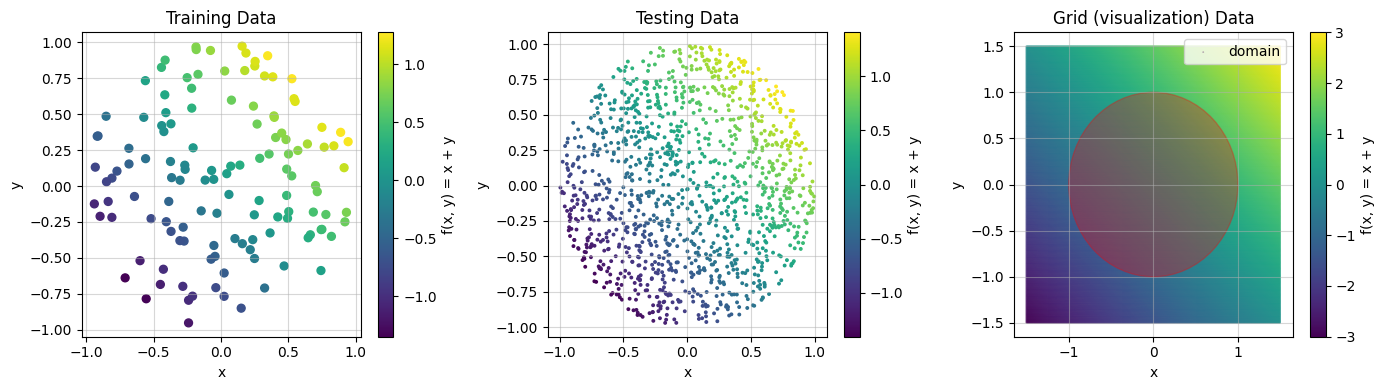

In [4]:
# show data
plt.figure(figsize=(14, 4))
s = 32
for i in range(3):
    plt.subplot(1, 3, 1 + i)
    if i==0:
        x, y = data.get_train()
        plt.title("Training Data")
    elif i==1:
        x, y = [], []
        for j in range(data.test_batch):
            x_, y_ = data.get_test(j)
            x.append(x_.copy())
            y.append(y_.copy())
        x = np.concatenate(x)
        y = np.concatenate(y)
        plt.title("Testing Data")
    else:
        x, y = data.x_grid, data.y_grid
        plt.title("Grid (visualization) Data")

    plt.grid(alpha=.5)
    plt.scatter(*x.T, c=y, s=s * batch_size / x.shape[0])
    plt.colorbar(label='f(x, y) = x + y')
    plt.xlabel('x')
    plt.ylabel('y')

plt.gca().add_patch(plt.Circle((0, 0), 1.0, color='r', fill=True, alpha=.3))
plt.legend(['domain'])

plt.tight_layout()
plt.show()

# Train MLPs

In [5]:
# train all ReLU models
grid_predictions, mse_trains, mse_tests, mse_ids, mse_oods = [], [], [], [], []

for i, num_hidden in enumerate(num_hiddens):
    model = Calculator(
        num_input=2,
        num_output=1,
        normalized=False,
        num_hidden=num_hidden,
        num_layer=2,
        sigma=1e0,
        nonlinearity=torch.nn.ReLU,
        normalization='std',
        seed=seed
    )
    print(
        'num_hidden:', num_hidden,
        'num parameter:', count_parameters(model),
        'model:', model
    )
    train_log = train(
        model, data, lr=lr, num_step=num_step, decayRate=decayRate
    )
    mse_train, mse_test = torch.tensor(train_log['mse_train']).mean(), torch.tensor(train_log['mse_test']).mean()
    assert not torch.isnan(mse_train).any(), breakpoint()
    mse_trains.append(mse_train)
    mse_tests.append(mse_test)

    torch.save(model.state_dict(), log_dir + "add_disc_relu_num_hidden=%s" % num_hidden)

    # compute predictions on grid
    model.eval()
    y_grid_ = model(x_grid_torch).detach().cpu().numpy()[:, 0]
    grid_predictions.append(y_grid_)
    mse_id = np.mean((y_grid[ind_id, 0] - y_grid_[ind_id])**2) # NOTE
    mse_ood = np.mean((y_grid[ind_ood, 0] - y_grid_[ind_ood])**2) # NOTE
    mse_ids.append(mse_id)
    mse_oods.append(mse_ood)

    print('MSE_train=%.4e, MSE_test=%.4e, MSE_grid_id=%.4e, MSE_grid_od=%.4e\n' % (
        mse_train, mse_test, mse_id, mse_ood
    ))

results = {
    'grid_predictions': np.array(grid_predictions),
    'mse_trains': np.array(mse_trains),
    'mse_tests': np.array(mse_tests),
    'mse_ids': np.array(mse_ids),
    'mse_oods': np.array(mse_oods),
}
with open(log_dir + 'add_disc_relu_results.pkl', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

num_hidden: 16 num parameter: 65 model: Calculator(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)


iteration 50000, losses: train=2.9334e-15, test=6.0133e-06, layer0_weight_std=4.7074e-01: 100%|█| 50001/


MSE_train=6.8965e-04, MSE_test=1.9226e-05, MSE_grid_id=5.2167e-06, MSE_grid_od=3.7095e-02

num_hidden: 64 num parameter: 257 model: Calculator(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


iteration 50000, losses: train=7.2989e-08, test=3.8481e-06, layer0_weight_std=4.3546e-01: 100%|█| 50001/


MSE_train=2.0281e-04, MSE_test=1.1286e-05, MSE_grid_id=4.0947e-06, MSE_grid_od=4.7285e-03

num_hidden: 256 num parameter: 1025 model: Calculator(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
)


iteration 50000, losses: train=1.4950e-09, test=6.2960e-06, layer0_weight_std=4.1278e-01: 100%|█| 50001/


MSE_train=1.7563e-04, MSE_test=6.9608e-06, MSE_grid_id=6.1649e-06, MSE_grid_od=5.4713e-03

num_hidden: 1024 num parameter: 4097 model: Calculator(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1, bias=True)
  )
)


iteration 50000, losses: train=9.5315e-11, test=4.9804e-06, layer0_weight_std=4.0317e-01: 100%|█| 50001/

MSE_train=4.2740e-05, MSE_test=5.1005e-06, MSE_grid_id=4.7547e-06, MSE_grid_od=1.2030e-03



In [6]:
# Train GPs with different length scales (sklearn)
mse_trains, mse_tests, mse_ids, mse_oods = [], [], [], []
grid_predictions, grid_stds = [], []

for length_scale in length_scales:
  model, output = train_gp(
    data,
    verbose=False,
    lengthscale=length_scale,
    framework='sklearn',
    seed=seed,
    grid_batch_size=10000,
  )

  mse_trains.append(output['mse_train'])
  mse_tests.append(output['mse_test'])
  grid_predictions.append(output['y_grid_'])
  grid_stds.append(output['std_grid'])
  mse_id = np.mean((y_grid[ind_id, 0] - output['y_grid_'][ind_id])**2)
  mse_ood = np.mean((y_grid[ind_ood, 0] - output['y_grid_'][ind_ood])**2)
  mse_ids.append(mse_id)
  mse_oods.append(mse_ood)

  print('length_scale=%s, MSE_train=%.4e, MSE_test=%.4e, MSE_grid_id=%.4e, '
        'MSE_grid_od=%.4e\n' % (length_scale, output['mse_train'],
                                output['mse_test'], mse_id, mse_ood
  ))

results = {
    'grid_predictions': np.array(grid_predictions),
    'grid_stds': np.array(grid_stds),
    'mse_trains': np.array(mse_trains),
    'mse_tests': np.array(mse_tests),
    'mse_ids': np.array(mse_ids),
    'mse_oods': np.array(mse_oods),
}
with open(log_dir + 'add_disc_gp_skl_results.pkl', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

length_scale=0.2, MSE_train=1.0002e+00, MSE_test=9.5581e-01, MSE_grid_id=1.1615e-03, MSE_grid_od=1.5526e+00

length_scale=1, MSE_train=1.0002e+00, MSE_test=9.7109e-01, MSE_grid_id=1.2326e-10, MSE_grid_od=1.1158e-03

length_scale=5, MSE_train=1.0002e+00, MSE_test=9.7110e-01, MSE_grid_id=1.7849e-12, MSE_grid_od=4.6690e-08

length_scale=50, MSE_train=1.0002e+00, MSE_test=9.7110e-01, MSE_grid_id=3.8823e-16, MSE_grid_od=1.6592e-14



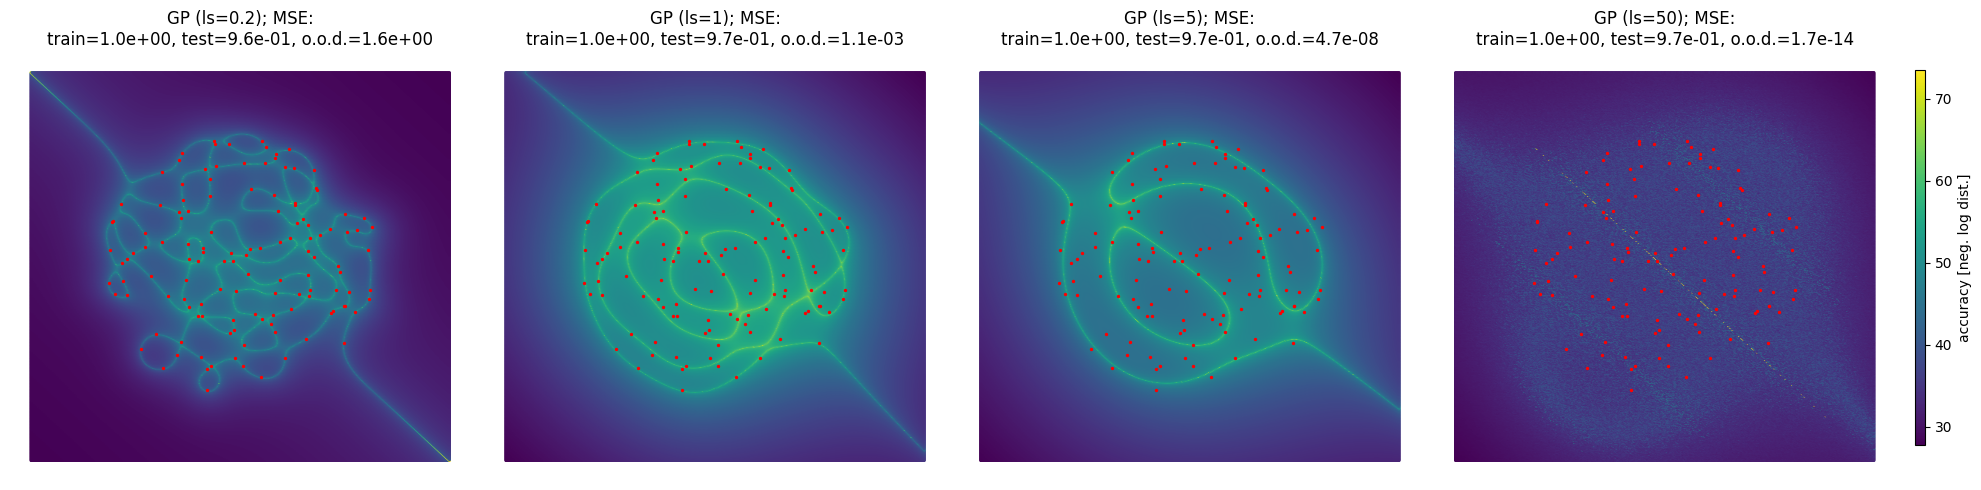

In [7]:
# show results
with open(log_dir + 'add_disc_gp_skl_results.pkl', 'rb') as handle:
    results = pickle.load(handle)

plt.figure(figsize=(20, 5))
for i, length_scale in enumerate(length_scales):
  plt.subplot(1, 4, 1 + i)
  # compute neg log dist
  y_ = grid_predictions[i]
  nld = neg_log_dist(y_grid[:, 0], y_)
  # plot
  im = plt.scatter(*x.T, c=nld, s=1)
  #plt.colorbar(label='accuracy [neg. log dist.]')  # individual colorbars
  plt.scatter(*data.get_train()[0].T, color='red', s=2)
  plt.title("GP (ls=%s); MSE:\ntrain=%.1e, test=%.1e, o.o.d.=%.1e" % (
      length_scale, results['mse_trains'][i], results['mse_tests'][i], 
      results['mse_oods'][i]))
  plt.axis('off')
plt.tight_layout()

# one shared colobar
fig = plt.gcf()
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.1, 0.005, 0.75])
fig.colorbar(im, cax=cbar_ax, label='accuracy [neg. log dist.]')

plt.show()

# Combined Figure

vmin vmax -2.1972245606466476 73.4736011393542


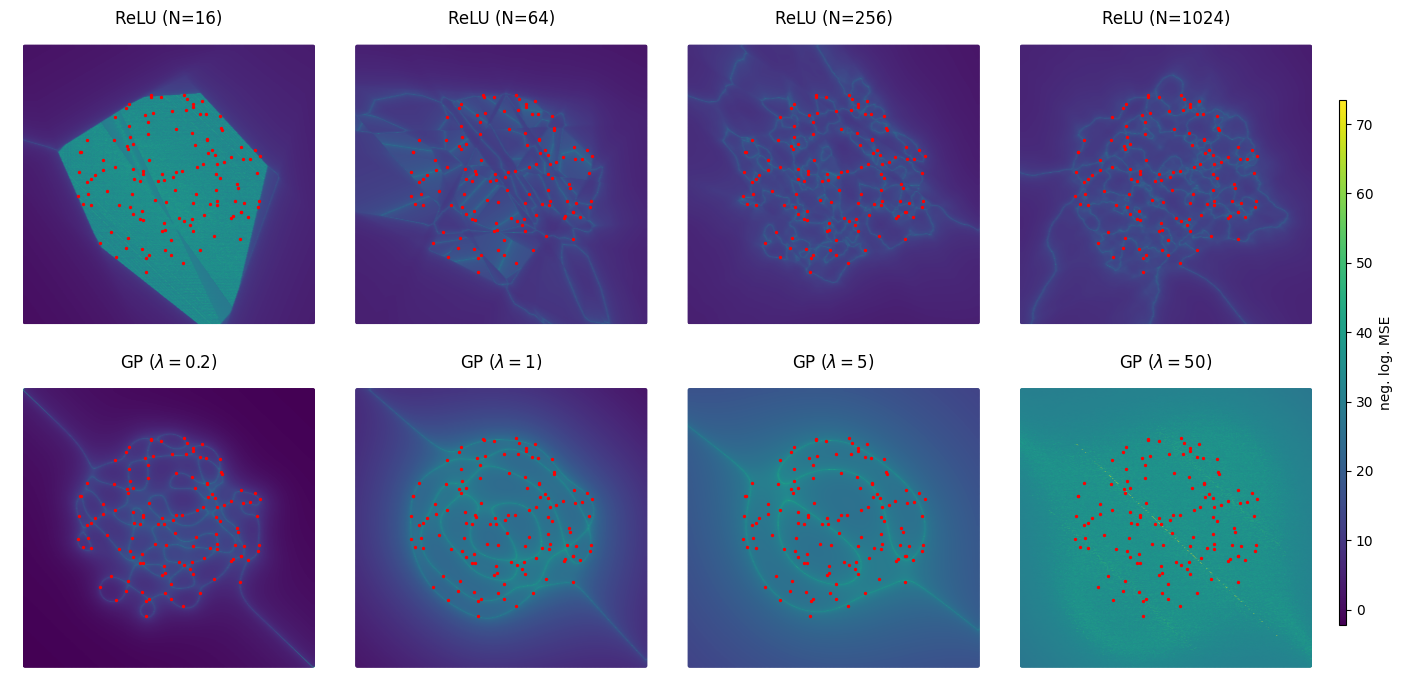

In [8]:
fig = plt.figure(figsize=(14, 7))

with open(log_dir + 'add_disc_relu_results.pkl', 'rb') as handle:
    results = pickle.load(handle)

vmin, vmax = 1e9, -1e9
for i, num_hidden in enumerate(num_hiddens):
  y_ = results['grid_predictions'][i]
  nld = neg_log_dist(y_grid[:, 0], y_)
  vmin = min(nld.min(), vmin)
  vmax = max(nld.max(), vmax)

with open(log_dir + 'add_disc_gp_skl_results.pkl', 'rb') as handle:
    results = pickle.load(handle)

for i, num_hidden in enumerate(num_hiddens):
  y_ = results['grid_predictions'][i]
  nld = neg_log_dist(y_grid[:, 0], y_)
  vmin = min(nld.min(), vmin)
  vmax = max(nld.max(), vmax)
print('vmin vmax', vmin, vmax)


### Top row: ReLU
with open(log_dir + 'add_disc_relu_results.pkl', 'rb') as handle:
    results = pickle.load(handle)
for i, num_hidden in enumerate(num_hiddens):
  plt.subplot(2, 4, 1 + i)
  y_ = results['grid_predictions'][i]
  nld = neg_log_dist(y_grid[:, 0], y_)
  im = plt.scatter(*x_grid.T, c=nld, s=1, vmin=vmin, vmax=vmax)
  #plt.colorbar(label='accuracy [neg. log dist.]')  # individual colorbars
  plt.scatter(*data.get_train()[0].T, color='red', s=2)
  plt.title("ReLU (N=%s)" % num_hidden)
  plt.axis('off')

### Bottom row: GP
with open(log_dir + 'add_disc_gp_skl_results.pkl', 'rb') as handle:
    results = pickle.load(handle)
for i, length_scale in enumerate(length_scales[::1]):
  plt.subplot(2, 4, 1 + i + 4)
  y_ = results['grid_predictions'][::1][i]
  nld = neg_log_dist(y_grid[:, 0], y_)
  im = plt.scatter(*x_grid.T, c=nld, s=1, vmin=vmin, vmax=vmax)
  #plt.colorbar(label='accuracy [neg. log dist.]')  # individual colorbars
  plt.scatter(*data.get_train()[0].T, color='red', s=2)
  plt.title(r"GP ($\lambda=%s$)" % length_scale)
  plt.axis('off')
plt.tight_layout()
fig = plt.gcf()
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.1, 0.005, 0.75])
fig.colorbar(im, cax=cbar_ax, label='neg. log. MSE')
plt.savefig(log_dir + 'fig1.png', dpi=500)
plt.show()

vmin vmax 0.0 2.9999999749656423


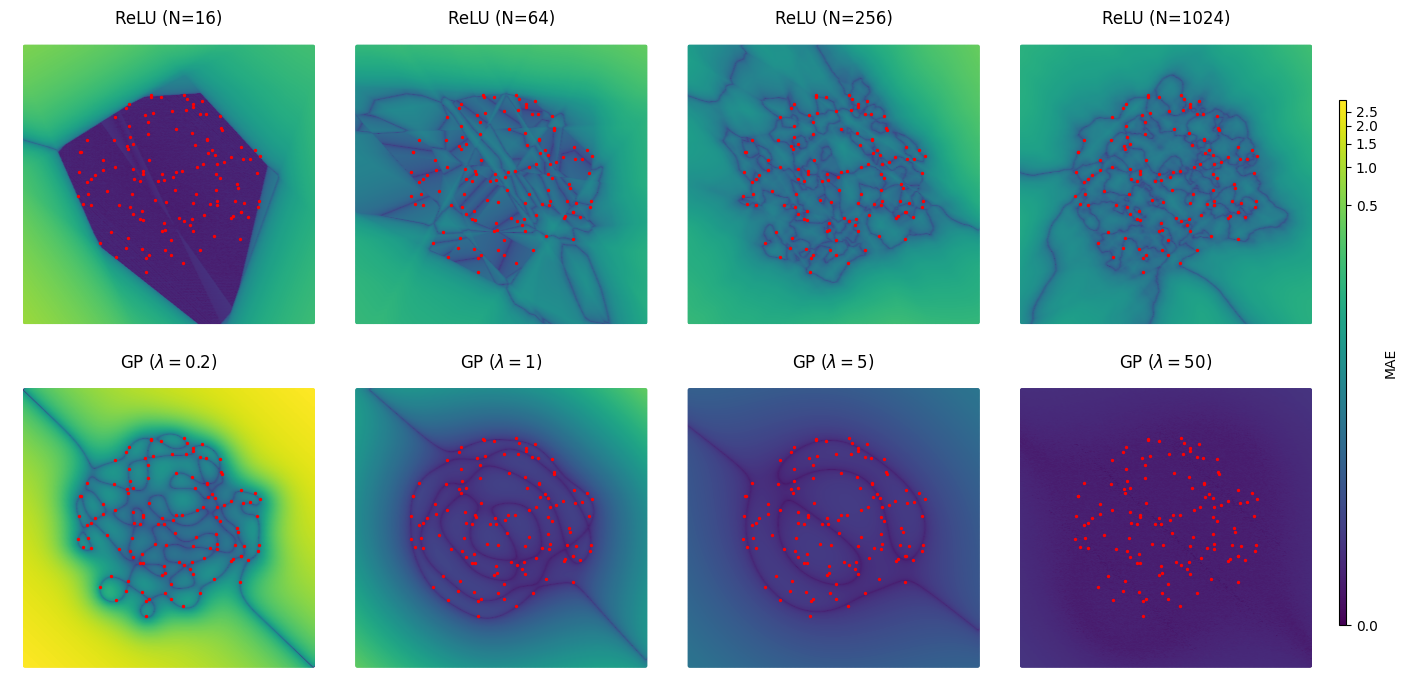

In [9]:
def se_dist(y, y_):
    out = np.abs(y - y_)
    # perfect_ind = out == 0.0
    # set perfect predictions to minimum error
    # out[perfect_ind] = np.min(out[np.logical_not(perfect_ind)])
    assert not np.any(np.isnan(out))
    assert not np.any(np.isinf(out))
    return out

fig = plt.figure(figsize=(14, 7))

with open(log_dir + 'add_disc_relu_results.pkl', 'rb') as handle:
    results = pickle.load(handle)

vmin, vmax = 1e9, -1e9
for i, num_hidden in enumerate(num_hiddens):
  y_ = results['grid_predictions'][i]
  nld = se_dist(y_grid[:, 0], y_)
  vmin = min(nld.min(), vmin)
  vmax = max(nld.max(), vmax)

with open(log_dir + 'add_disc_gp_skl_results.pkl', 'rb') as handle:
    results = pickle.load(handle)

for i, num_hidden in enumerate(num_hiddens):
  y_ = results['grid_predictions'][i]
  nld = se_dist(y_grid[:, 0], y_)
  vmin = min(nld.min(), vmin)
  vmax = max(nld.max(), vmax)
print('vmin vmax', vmin, vmax)

#norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
norm = matplotlib.colors.PowerNorm(gamma=1./8., vmin=vmin, vmax=vmax)


### Top row: ReLU
with open(log_dir + 'add_disc_relu_results.pkl', 'rb') as handle:
    results = pickle.load(handle)
for i, num_hidden in enumerate(num_hiddens):
  plt.subplot(2, 4, 1 + i)
  y_ = results['grid_predictions'][i]
  nld = se_dist(y_grid[:, 0], y_)
  im = plt.scatter(*x_grid.T, c=nld, s=1, norm=norm)
  #plt.colorbar(label='accuracy [neg. log dist.]')  # individual colorbars
  plt.scatter(*data.get_train()[0].T, color='red', s=2)
  plt.title("ReLU (N=%s)" % num_hidden)
  plt.axis('off')

### Bottom row: GP
with open(log_dir + 'add_disc_gp_skl_results.pkl', 'rb') as handle:
    results = pickle.load(handle)
for i, length_scale in enumerate(length_scales[::1]):
  plt.subplot(2, 4, 1 + i + 4)
  y_ = results['grid_predictions'][::1][i]
  nld = se_dist(y_grid[:, 0], y_)
  im = plt.scatter(*x_grid.T, c=nld, s=1, norm=norm)
  #plt.colorbar(label='accuracy [neg. log dist.]')  # individual colorbars
  plt.scatter(*data.get_train()[0].T, color='red', s=2)
  plt.title(r"GP ($\lambda=%s$)" % length_scale)
  plt.axis('off')
plt.tight_layout()
fig = plt.gcf()
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.1, 0.005, 0.75])
fig.colorbar(im, cax=cbar_ax, label='MAE')
plt.savefig(log_dir + 'fig1.png', dpi=500)
plt.show()

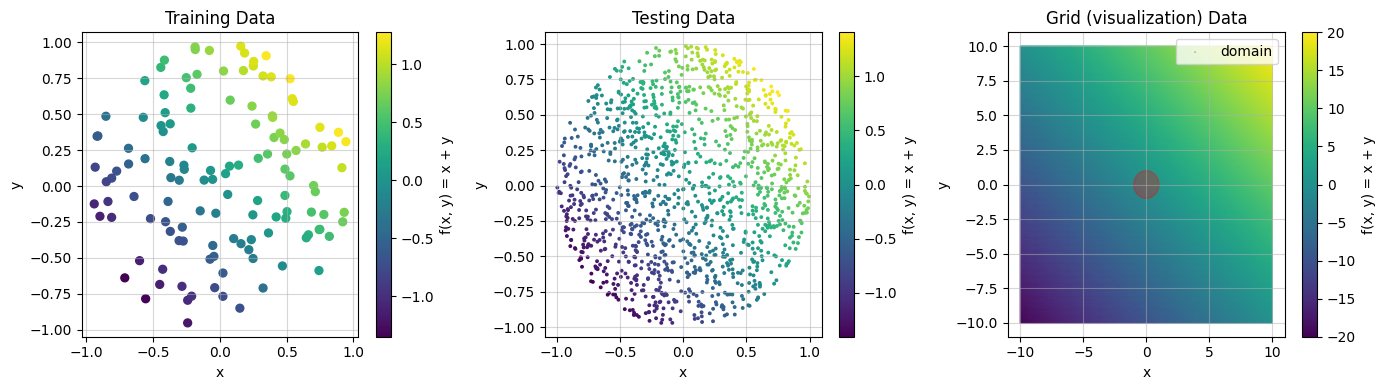

In [10]:
# make data
grid_limit = 10
data = Data(
    setting=setting, 
    batch_size=batch_size, 
    train_batch=train_batch,
    test_batch=test_batch,
    seed=seed,
    num_grid=num_grid,
    grid_limit=grid_limit,
)

# grid data
x_grid, y_grid = data.x_grid, data.y_grid
ind_id = np.linalg.norm(x_grid, axis=1) <= 1  # in domain
ind_ood = np.logical_not(ind_id)  # out of domain
x_grid_torch = torch.from_numpy(x_grid.astype(np.float32)).to(device)

# show data
plt.figure(figsize=(14, 4))
s = 32
for i in range(3):
    plt.subplot(1, 3, 1 + i)
    if i==0:
        x, y = data.get_train()
        plt.title("Training Data")
    elif i==1:
        x, y = [], []
        for j in range(data.test_batch):
            x_, y_ = data.get_test(j)
            x.append(x_.copy())
            y.append(y_.copy())
        x = np.concatenate(x)
        y = np.concatenate(y)
        plt.title("Testing Data")
    else:
        x, y = data.x_grid, data.y_grid
        plt.title("Grid (visualization) Data")

    plt.grid(alpha=.5)
    plt.scatter(*x.T, c=y, s=s * batch_size / x.shape[0])
    plt.colorbar(label='f(x, y) = x + y')
    plt.xlabel('x')
    plt.ylabel('y')

plt.gca().add_patch(plt.Circle((0, 0), 1.0, color='r', fill=True, alpha=.3))
plt.legend(['domain'])

plt.tight_layout()
plt.show()


In [11]:
# train all ReLU models
grid_predictions, mse_trains, mse_tests, mse_ids, mse_oods = [], [], [], [], []

for i, num_hidden in enumerate(num_hiddens):
    model = Calculator(
        num_input=2,
        num_output=1,
        normalized=False,
        num_hidden=num_hidden,
        num_layer=2,
        sigma=1e0,
        nonlinearity=torch.nn.ReLU,
        normalization='std',
        seed=seed
    )
    print(
        'num_hidden:', num_hidden,
        'num parameter:', count_parameters(model),
        'model:', model
    )
    train_log = train(
        model, data, lr=lr, num_step=num_step, decayRate=decayRate
    )
    mse_train, mse_test = torch.tensor(train_log['mse_train']).mean(), torch.tensor(train_log['mse_test']).mean()
    assert not torch.isnan(mse_train).any(), breakpoint()
    mse_trains.append(mse_train)
    mse_tests.append(mse_test)

    torch.save(model.state_dict(), log_dir + "add_disc_relu_num_hidden=%s" % num_hidden)

    # compute predictions on grid
    model.eval()
    y_grid_ = model(x_grid_torch).detach().cpu().numpy()[:, 0]
    grid_predictions.append(y_grid_)
    mse_id = np.mean((y_grid[ind_id, 0] - y_grid_[ind_id])**2) # NOTE
    mse_ood = np.mean((y_grid[ind_ood, 0] - y_grid_[ind_ood])**2) # NOTE
    mse_ids.append(mse_id)
    mse_oods.append(mse_ood)

    print('MSE_train=%.4e, MSE_test=%.4e, MSE_grid_id=%.4e, MSE_grid_od=%.4e\n' % (
        mse_train, mse_test, mse_id, mse_ood
    ))

results = {
    'grid_predictions': np.array(grid_predictions),
    'mse_trains': np.array(mse_trains),
    'mse_tests': np.array(mse_tests),
    'mse_ids': np.array(mse_ids),
    'mse_oods': np.array(mse_oods),
}
with open(log_dir + 'add_disc_relu_results.pkl', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

num_hidden: 16 num parameter: 65 model: Calculator(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)


iteration 50000, losses: train=2.9334e-15, test=6.0133e-06, layer0_weight_std=4.7074e-01: 100%|█| 50001/


MSE_train=6.8965e-04, MSE_test=1.9226e-05, MSE_grid_id=5.3599e-06, MSE_grid_od=8.6103e+00

num_hidden: 64 num parameter: 257 model: Calculator(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


iteration 50000, losses: train=7.2989e-08, test=3.8481e-06, layer0_weight_std=4.3546e-01: 100%|█| 50001/


MSE_train=2.0281e-04, MSE_test=1.1286e-05, MSE_grid_id=4.0629e-06, MSE_grid_od=2.4688e+00

num_hidden: 256 num parameter: 1025 model: Calculator(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
)


iteration 50000, losses: train=1.4950e-09, test=6.2960e-06, layer0_weight_std=4.1278e-01: 100%|█| 50001/


MSE_train=1.7563e-04, MSE_test=6.9608e-06, MSE_grid_id=6.2778e-06, MSE_grid_od=1.8977e+00

num_hidden: 1024 num parameter: 4097 model: Calculator(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1, bias=True)
  )
)


iteration 50000, losses: train=9.5315e-11, test=4.9804e-06, layer0_weight_std=4.0317e-01: 100%|█| 50001/

MSE_train=4.2740e-05, MSE_test=5.1005e-06, MSE_grid_id=4.8339e-06, MSE_grid_od=7.8047e-01



In [12]:
# train all PReLU models
grid_predictions, mse_trains, mse_tests, mse_ids, mse_oods = [], [], [], [], []

for i, num_hidden in enumerate(num_hiddens):
    model = Calculator(
        num_input=2,
        num_output=1,
        normalized=False,
        num_hidden=num_hidden,
        num_layer=2,
        sigma=1e0,
        nonlinearity=torch.nn.PReLU,
        normalization='std',
        seed=seed
    )

    train_log = train(
        model, data, lr=lr, num_step=num_step, decayRate=decayRate
    )
    print(
        'num_hidden:', num_hidden,
        'num parameter:', count_parameters(model),
        'model:', model,
        'prelu:', dict(model.layers[1].named_parameters()),
    )

    mse_train, mse_test = torch.tensor(train_log['mse_train']).mean(), torch.tensor(train_log['mse_test']).mean()
    assert not torch.isnan(mse_train).any(), breakpoint()
    mse_trains.append(mse_train)
    mse_tests.append(mse_test)

    torch.save(model.state_dict(), log_dir + "add_disc_prelu_num_hidden=%s" % num_hidden)

    # compute predictions on grid
    model.eval()
    y_grid_ = model(x_grid_torch).detach().cpu().numpy()[:, 0]
    grid_predictions.append(y_grid_)
    mse_id = np.mean((y_grid[ind_id, 0] - y_grid_[ind_id])**2) # NOTE
    mse_ood = np.mean((y_grid[ind_ood, 0] - y_grid_[ind_ood])**2) # NOTE
    mse_ids.append(mse_id)
    mse_oods.append(mse_ood)

    print('MSE_train=%.4e, MSE_test=%.4e, MSE_grid_id=%.4e, MSE_grid_od=%.4e\n' % (
        mse_train, mse_test, mse_id, mse_ood
    ))

results = {
    'grid_predictions': np.array(grid_predictions),
    'mse_trains': np.array(mse_trains),
    'mse_tests': np.array(mse_tests),
    'mse_ids': np.array(mse_ids),
    'mse_oods': np.array(mse_oods),
}
with open(log_dir + 'add_disc_prelu_results.pkl', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

iteration 50000, losses: train=1.7175e-13, test=2.7169e-07, layer0_weight_std=4.6098e-01: 100%|█| 50001/


num_hidden: 16 num parameter: 66 model: Calculator(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
) prelu: {'weight': Parameter containing:
tensor([0.6412], device='cuda:0', requires_grad=True)}
MSE_train=5.8506e-04, MSE_test=1.4333e-05, MSE_grid_id=2.5149e-07, MSE_grid_od=3.1823e-01



iteration 50000, losses: train=2.3893e-08, test=1.0049e-06, layer0_weight_std=4.3059e-01: 100%|█| 50001/


num_hidden: 64 num parameter: 258 model: Calculator(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
) prelu: {'weight': Parameter containing:
tensor([0.3734], device='cuda:0', requires_grad=True)}
MSE_train=1.2189e-04, MSE_test=3.7784e-06, MSE_grid_id=8.7370e-07, MSE_grid_od=3.3768e-01



iteration 50000, losses: train=1.2202e-09, test=2.5190e-06, layer0_weight_std=4.1024e-01: 100%|█| 50001/


num_hidden: 256 num parameter: 1026 model: Calculator(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
) prelu: {'weight': Parameter containing:
tensor([0.2806], device='cuda:0', requires_grad=True)}
MSE_train=1.5241e-04, MSE_test=3.5181e-06, MSE_grid_id=2.3138e-06, MSE_grid_od=2.5434e-01



iteration 50000, losses: train=1.2670e-10, test=1.7236e-06, layer0_weight_std=4.0294e-01: 100%|█| 50001/

num_hidden: 1024 num parameter: 4098 model: Calculator(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=1, bias=True)
  )
) prelu: {'weight': Parameter containing:
tensor([0.2452], device='cuda:0', requires_grad=True)}
MSE_train=3.7014e-05, MSE_test=1.9411e-06, MSE_grid_id=1.8840e-06, MSE_grid_od=1.1491e-01



In [13]:
# train all normalized tanh models
grid_predictions, mse_trains, mse_tests, mse_ids, mse_oods = [], [], [], [], []

for i, num_hidden in enumerate(num_hiddens):
    model = Calculator(
        num_input=2,
        num_output=1,
        normalized=True,
        num_hidden=num_hidden,
        num_layer=2,
        sigma=1e0,
        nonlinearity=torch.nn.Tanh,
        normalization='tanh',
        seed=seed
    )
    print(
        'num_hidden:', num_hidden,
        'num parameter:', count_parameters(model),
        'model:', model
    )
    train_log = train(
        model, data, lr=lr, num_step=num_step, decayRate=decayRate
    )
    mse_train, mse_test = torch.tensor(train_log['mse_train']).mean(), torch.tensor(train_log['mse_test']).mean()
    assert not torch.isnan(mse_train).any(), breakpoint()
    mse_trains.append(mse_train)
    mse_tests.append(mse_test)

    torch.save(model.state_dict(), log_dir + "add_disc_normtanh_num_hidden=%s" % num_hidden)

    # compute predictions on grid
    model.eval()
    y_grid_ = model(x_grid_torch).detach().cpu().numpy()[:, 0]
    grid_predictions.append(y_grid_)
    mse_id = np.mean((y_grid[ind_id, 0] - y_grid_[ind_id])**2) # NOTE
    mse_ood = np.mean((y_grid[ind_ood, 0] - y_grid_[ind_ood])**2) # NOTE
    mse_ids.append(mse_id)
    mse_oods.append(mse_ood)

    print('MSE_train=%.4e, MSE_test=%.4e, MSE_grid_id=%.4e, MSE_grid_od=%.4e\n' % (
        mse_train, mse_test, mse_id, mse_ood
    ))

results = {
    'grid_predictions': np.array(grid_predictions),
    'mse_trains': np.array(mse_trains),
    'mse_tests': np.array(mse_tests),
    'mse_ids': np.array(mse_ids),
    'mse_oods': np.array(mse_oods),
}
with open(log_dir + 'add_disc_normtanh_results.pkl', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

num_hidden: 16 num parameter: 65 model: Calculator(
  (layers): Sequential(
    (0): NormalizedLinear()
    (1): Tanh()
    (2): NormalizedLinear()
  )
)


iteration 50000, losses: train=8.9174e-06, test=1.1336e-05, layer0_weight_std=1.2327e+00: 100%|█| 50001/


MSE_train=4.3970e-03, MSE_test=6.0698e-04, MSE_grid_id=1.1384e-05, MSE_grid_od=3.4757e+01

num_hidden: 64 num parameter: 257 model: Calculator(
  (layers): Sequential(
    (0): NormalizedLinear()
    (1): Tanh()
    (2): NormalizedLinear()
  )
)


iteration 50000, losses: train=7.1264e-07, test=1.3242e-06, layer0_weight_std=9.8242e-01: 100%|█| 50001/


MSE_train=3.5154e-03, MSE_test=4.5590e-05, MSE_grid_id=1.2651e-06, MSE_grid_od=3.2304e+01

num_hidden: 256 num parameter: 1025 model: Calculator(
  (layers): Sequential(
    (0): NormalizedLinear()
    (1): Tanh()
    (2): NormalizedLinear()
  )
)


iteration 50000, losses: train=2.8073e-07, test=5.3616e-07, layer0_weight_std=9.8360e-01: 100%|█| 50001/


MSE_train=8.6801e-04, MSE_test=1.7992e-05, MSE_grid_id=5.4372e-07, MSE_grid_od=3.0037e+01

num_hidden: 1024 num parameter: 4097 model: Calculator(
  (layers): Sequential(
    (0): NormalizedLinear()
    (1): Tanh()
    (2): NormalizedLinear()
  )
)


iteration 50000, losses: train=1.8317e-07, test=3.3542e-07, layer0_weight_std=9.8194e-01: 100%|█| 50001/


MSE_train=4.6413e-04, MSE_test=2.0249e-05, MSE_grid_id=3.4110e-07, MSE_grid_od=2.9220e+01



In [14]:
# train all LINEARITY models
grid_predictions, mse_trains, mse_tests, mse_ids, mse_oods = [], [], [], [], []

for i, num_hidden in enumerate(num_hiddens):
    model = Calculator(
        num_input=2,
        num_output=1,
        normalized=False,
        num_hidden=num_hidden,
        num_layer=2,
        sigma=1e0,
        nonlinearity=torch.nn.Identity,
        normalization='std',
        seed=seed
    )
    print(
        'num_hidden:', num_hidden,
        'num parameter:', count_parameters(model),
        'model:', model
    )
    train_log = train(
        model, data, lr=lr, num_step=num_step, decayRate=decayRate
    )
    mse_train, mse_test = torch.tensor(train_log['mse_train']).mean(), torch.tensor(train_log['mse_test']).mean()
    assert not torch.isnan(mse_train).any(), breakpoint()
    mse_trains.append(mse_train)
    mse_tests.append(mse_test)

    torch.save(model.state_dict(), log_dir + "add_disc_id_num_hidden=%s" % num_hidden)

    # compute predictions on grid
    model.eval()
    y_grid_ = model(x_grid_torch).detach().cpu().numpy()[:, 0]
    grid_predictions.append(y_grid_)
    mse_id = np.mean((y_grid[ind_id, 0] - y_grid_[ind_id])**2) # NOTE
    mse_ood = np.mean((y_grid[ind_ood, 0] - y_grid_[ind_ood])**2) # NOTE
    mse_ids.append(mse_id)
    mse_oods.append(mse_ood)

    print('MSE_train=%.4e, MSE_test=%.4e, MSE_grid_id=%.4e, MSE_grid_od=%.4e\n' % (
        mse_train, mse_test, mse_id, mse_ood
    ))

results = {
    'grid_predictions': np.array(grid_predictions),
    'mse_trains': np.array(mse_trains),
    'mse_tests': np.array(mse_tests),
    'mse_ids': np.array(mse_ids),
    'mse_oods': np.array(mse_oods),
}
with open(log_dir + 'add_disc_id_results.pkl', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

num_hidden: 16 num parameter: 65 model: Calculator(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Identity()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)


iteration 50000, losses: train=1.6085e-15, test=1.9411e-15, layer0_weight_std=4.8386e-01: 100%|█| 50001/


MSE_train=4.4671e-04, MSE_test=1.2090e-13, MSE_grid_id=2.1403e-15, MSE_grid_od=2.6605e-13

num_hidden: 64 num parameter: 257 model: Calculator(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Identity()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


iteration 50000, losses: train=2.7235e-15, test=2.3007e-15, layer0_weight_std=4.2432e-01: 100%|█| 50001/


MSE_train=4.5540e-05, MSE_test=2.0838e-15, MSE_grid_id=3.5900e-15, MSE_grid_od=3.4708e-13

num_hidden: 256 num parameter: 1025 model: Calculator(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): Identity()
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
)


iteration 50000, losses: train=3.0490e-15, test=3.1336e-15, layer0_weight_std=4.0756e-01: 100%|█| 50001/


MSE_train=1.2012e-04, MSE_test=2.6478e-08, MSE_grid_id=2.3258e-15, MSE_grid_od=2.3446e-13

num_hidden: 1024 num parameter: 4097 model: Calculator(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=1024, bias=True)
    (1): Identity()
    (2): Linear(in_features=1024, out_features=1, bias=True)
  )
)


iteration 50000, losses: train=2.7415e-15, test=2.5818e-15, layer0_weight_std=4.0335e-01: 100%|█| 50001/

MSE_train=3.7976e-05, MSE_test=1.4625e-06, MSE_grid_id=3.9222e-15, MSE_grid_od=4.7495e-13



In [15]:
# Train GPs with different length scales (sklearn)
mse_trains, mse_tests, mse_ids, mse_oods = [], [], [], []
grid_predictions, grid_stds = [], []

for length_scale in length_scales:
  model, output = train_gp(
    data,
    verbose=False,
    lengthscale=length_scale,
    framework='sklearn',
    seed=seed,
    grid_batch_size=10000,
  )

  mse_trains.append(output['mse_train'])
  mse_tests.append(output['mse_test'])
  grid_predictions.append(output['y_grid_'])
  grid_stds.append(output['std_grid'])
  mse_id = np.mean((y_grid[ind_id, 0] - output['y_grid_'][ind_id])**2)
  mse_ood = np.mean((y_grid[ind_ood, 0] - output['y_grid_'][ind_ood])**2)
  mse_ids.append(mse_id)
  mse_oods.append(mse_ood)

  print('length_scale=%s, MSE_train=%.4e, MSE_test=%.4e, MSE_grid_id=%.4e, '
        'MSE_grid_od=%.4e\n' % (length_scale, output['mse_train'],
                                output['mse_test'], mse_id, mse_ood
  ))

results = {
    'grid_predictions': np.array(grid_predictions),
    'grid_stds': np.array(grid_stds),
    'mse_trains': np.array(mse_trains),
    'mse_tests': np.array(mse_tests),
    'mse_ids': np.array(mse_ids),
    'mse_oods': np.array(mse_oods),
}
with open(log_dir + 'add_disc_gp_skl_results.pkl', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

length_scale=0.2, MSE_train=1.0002e+00, MSE_test=9.5581e-01, MSE_grid_id=1.2119e-03, MSE_grid_od=6.7445e+01

length_scale=1, MSE_train=1.0002e+00, MSE_test=9.7109e-01, MSE_grid_id=1.2761e-10, MSE_grid_od=6.6797e+01

length_scale=5, MSE_train=1.0002e+00, MSE_test=9.7110e-01, MSE_grid_id=1.8309e-12, MSE_grid_od=9.6954e+00

length_scale=50, MSE_train=1.0002e+00, MSE_test=9.7110e-01, MSE_grid_id=3.9511e-16, MSE_grid_od=4.3654e-06



vmin vmax 0.0 20.0


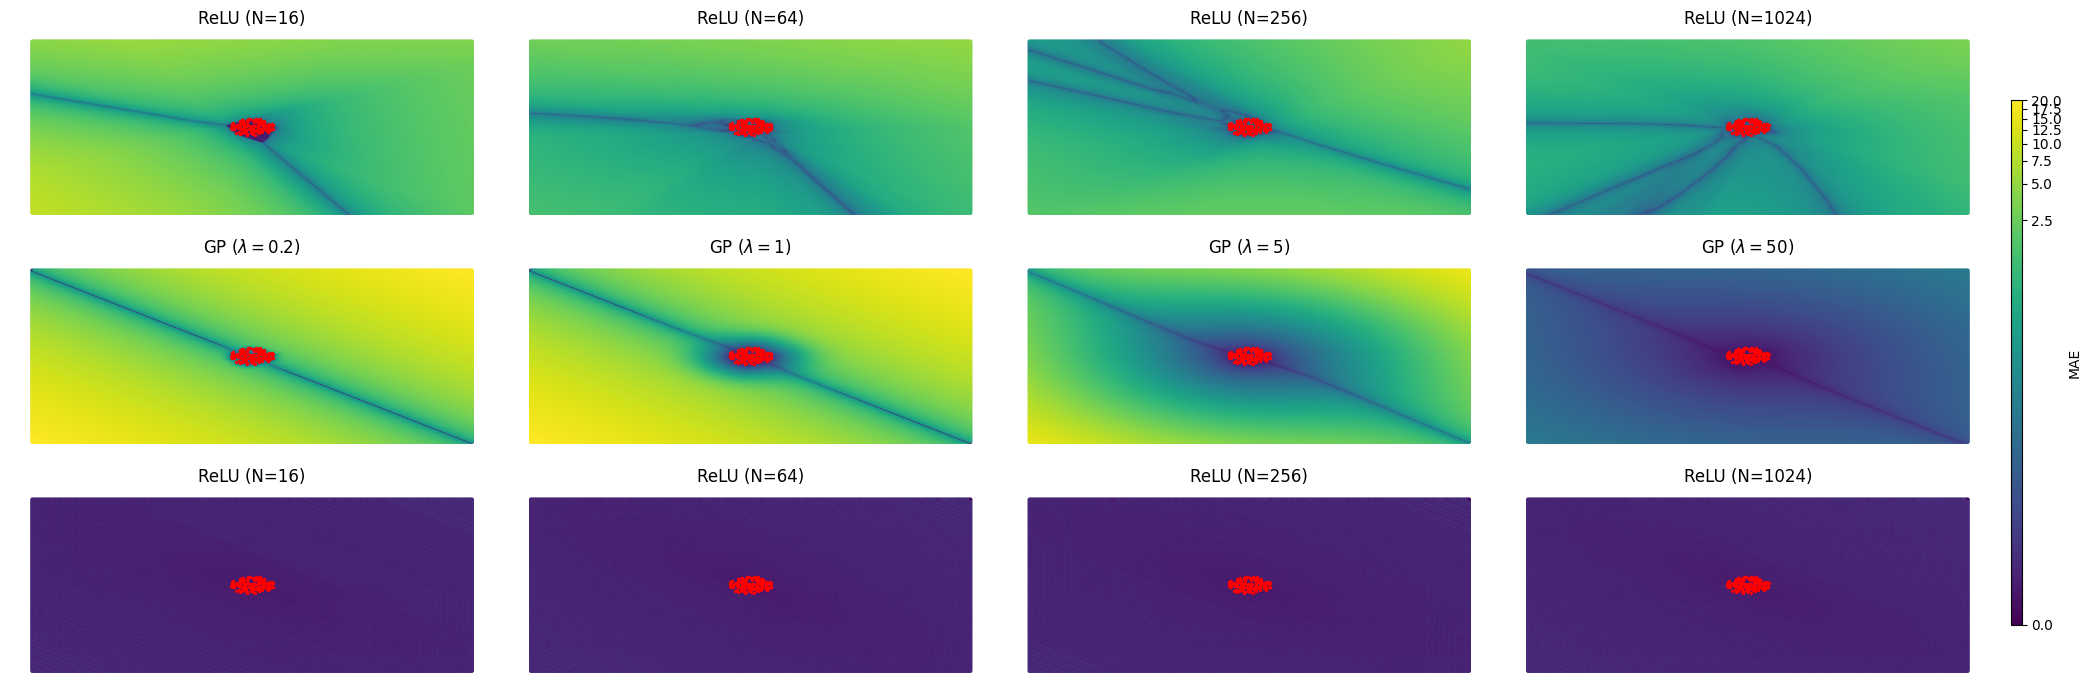

In [16]:
def se_dist(y, y_):
    out = np.abs(y - y_)
    # perfect_ind = out == 0.0
    # set perfect predictions to minimum error
    # out[perfect_ind] = np.min(out[np.logical_not(perfect_ind)])
    assert not np.any(np.isnan(out))
    assert not np.any(np.isinf(out))
    return out

fig = plt.figure(figsize=(21, 7))

with open(log_dir + 'add_disc_relu_results.pkl', 'rb') as handle:
    results = pickle.load(handle)

vmin, vmax = 1e9, -1e9
for i, num_hidden in enumerate(num_hiddens):
  y_ = results['grid_predictions'][i]
  nld = se_dist(y_grid[:, 0], y_)
  vmin = min(nld.min(), vmin)
  vmax = max(nld.max(), vmax)


with open(log_dir + 'add_disc_id_results.pkl', 'rb') as handle:
    results = pickle.load(handle)

vmin, vmax = 1e9, -1e9
for i, num_hidden in enumerate(num_hiddens):
  y_ = results['grid_predictions'][i]
  nld = se_dist(y_grid[:, 0], y_)
  vmin = min(nld.min(), vmin)
  vmax = max(nld.max(), vmax)

with open(log_dir + 'add_disc_gp_skl_results.pkl', 'rb') as handle:
    results = pickle.load(handle)

for i, num_hidden in enumerate(num_hiddens):
  y_ = results['grid_predictions'][i]
  nld = se_dist(y_grid[:, 0], y_)
  vmin = min(nld.min(), vmin)
  vmax = max(nld.max(), vmax)
print('vmin vmax', vmin, vmax)

#norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
norm = matplotlib.colors.PowerNorm(gamma=1./8., vmin=vmin, vmax=vmax)


### Top row: ReLU
with open(log_dir + 'add_disc_relu_results.pkl', 'rb') as handle:
    results = pickle.load(handle)
for i, num_hidden in enumerate(num_hiddens):
  plt.subplot(3, 4, 1 + i)
  y_ = results['grid_predictions'][i]
  nld = se_dist(y_grid[:, 0], y_)
  im = plt.scatter(*x_grid.T, c=nld, s=1, norm=norm)
  #plt.colorbar(label='accuracy [neg. log dist.]')  # individual colorbars
  plt.scatter(*data.get_train()[0].T, color='red', s=2)
  plt.title("ReLU (N=%s)" % num_hidden)
  plt.axis('off')

### Bottom row: GP
with open(log_dir + 'add_disc_gp_skl_results.pkl', 'rb') as handle:
    results = pickle.load(handle)
for i, length_scale in enumerate(length_scales[::1]):
  plt.subplot(3, 4, 1 + i + 4)
  y_ = results['grid_predictions'][::1][i]
  nld = se_dist(y_grid[:, 0], y_)
  im = plt.scatter(*x_grid.T, c=nld, s=1, norm=norm)
  #plt.colorbar(label='accuracy [neg. log dist.]')  # individual colorbars
  plt.scatter(*data.get_train()[0].T, color='red', s=2)
  plt.title(r"GP ($\lambda=%s$)" % length_scale)
  plt.axis('off')

### Bottomest row: Identity 'nonlinearity'
with open(log_dir + 'add_disc_id_results.pkl', 'rb') as handle:
    results = pickle.load(handle)
for i, num_hidden in enumerate(num_hiddens):
  plt.subplot(3, 4, 1 + i + 8)
  y_ = results['grid_predictions'][i]
  nld = se_dist(y_grid[:, 0], y_)
  im = plt.scatter(*x_grid.T, c=nld, s=1, norm=norm)
  #plt.colorbar(label='accuracy [neg. log dist.]')  # individual colorbars
  plt.scatter(*data.get_train()[0].T, color='red', s=2)
  plt.title("ReLU (N=%s)" % num_hidden)
  plt.axis('off')
    
plt.tight_layout()
fig = plt.gcf()
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.1, 0.005, 0.75])
fig.colorbar(im, cax=cbar_ax, label='MAE')
plt.savefig(log_dir + 'fig1.png', dpi=500)
plt.show()

vmin vmax 0.0 15.717621803283691


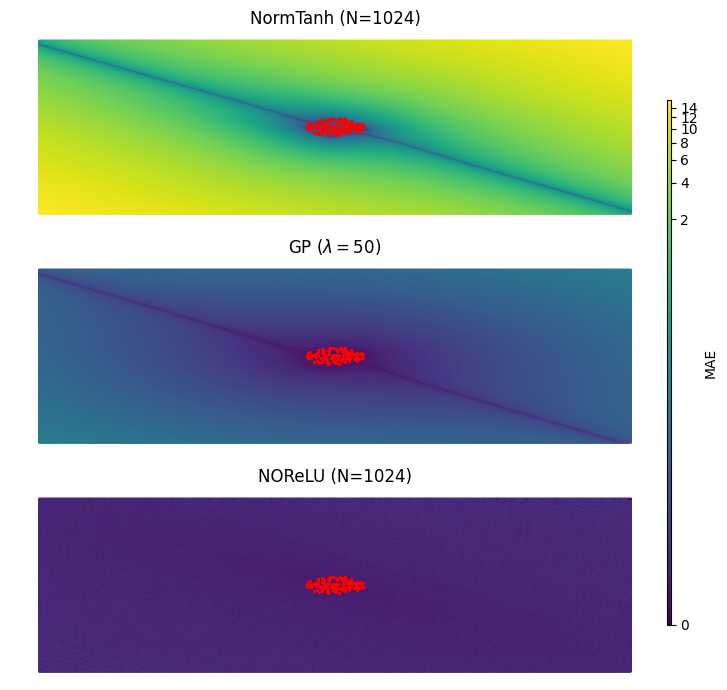

In [17]:
fig = plt.figure(figsize=(7, 7))
num_hiddens = [1024]
length_scales = [50]


vmin, vmax = 1e9, -1e9
with open(log_dir + 'add_disc_normtanh_results.pkl', 'rb') as handle:
    results = pickle.load(handle)

for i, num_hidden in enumerate(num_hiddens):
  y_ = results['grid_predictions'][i+3]
  nld = se_dist(y_grid[:, 0], y_)
  vmin = min(nld.min(), vmin)
  vmax = max(nld.max(), vmax)

with open(log_dir + 'add_disc_id_results.pkl', 'rb') as handle:
    results = pickle.load(handle)

for i, num_hidden in enumerate(num_hiddens):
  y_ = results['grid_predictions'][i+3]
  nld = se_dist(y_grid[:, 0], y_)
  vmin = min(nld.min(), vmin)
  vmax = max(nld.max(), vmax)
    
with open(log_dir + 'add_disc_gp_skl_results.pkl', 'rb') as handle:
    results = pickle.load(handle)

for i, num_hidden in enumerate(num_hiddens):
  y_ = results['grid_predictions'][i+3]
  nld = se_dist(y_grid[:, 0], y_)
  vmin = min(nld.min(), vmin)
  vmax = max(nld.max(), vmax)
print('vmin vmax', vmin, vmax)

#norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
norm = matplotlib.colors.PowerNorm(gamma=1./8., vmin=vmin, vmax=vmax)

### Top row: ReLU
with open(log_dir + 'add_disc_normtanh_results.pkl', 'rb') as handle:
    results = pickle.load(handle)
for i, num_hidden in enumerate(num_hiddens):
  plt.subplot(3, 1, 1 + i)
  y_ = results['grid_predictions'][i+3]
  nld = se_dist(y_grid[:, 0], y_)
  im = plt.scatter(*x_grid.T, c=nld, s=1, norm=norm)
  #plt.colorbar(label='accuracy [neg. log dist.]')  # individual colorbars
  plt.scatter(*data.get_train()[0].T, color='red', s=2)
  plt.title("NormTanh (N=%s)" % num_hidden)
  plt.axis('off')

### Bottom row: GP
with open(log_dir + 'add_disc_gp_skl_results.pkl', 'rb') as handle:
    results = pickle.load(handle)
for i, length_scale in enumerate(length_scales[::1]):
  plt.subplot(3, 1, 1 + i+1)
  y_ = results['grid_predictions'][::1][i+3]
  nld = se_dist(y_grid[:, 0], y_)
  im = plt.scatter(*x_grid.T, c=nld, s=1, norm=norm)
  #plt.colorbar(label='accuracy [neg. log dist.]')  # individual colorbars
  plt.scatter(*data.get_train()[0].T, color='red', s=2)
  plt.title(r"GP ($\lambda=%s$)" % length_scale)
  plt.axis('off')

### Bottomest row: Identity 'nonlinearity'
with open(log_dir + 'add_disc_id_results.pkl', 'rb') as handle:
    results = pickle.load(handle)
for i, num_hidden in enumerate(num_hiddens):
  plt.subplot(3, 1, 1 + i + 2)
  y_ = results['grid_predictions'][i+3]
  nld = se_dist(y_grid[:, 0], y_)
  im = plt.scatter(*x_grid.T, c=nld, s=1, norm=norm)
  #plt.colorbar(label='accuracy [neg. log dist.]')  # individual colorbars
  plt.scatter(*data.get_train()[0].T, color='red', s=2)
  plt.title("NOReLU (N=%s)" % num_hidden)
  plt.axis('off')
    
plt.tight_layout()
fig = plt.gcf()
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.1, 0.005, 0.75])
fig.colorbar(im, cax=cbar_ax, label='MAE')
plt.savefig(log_dir + 'fig1.png', dpi=500)
plt.show()

vmin vmax 0.0 20.0


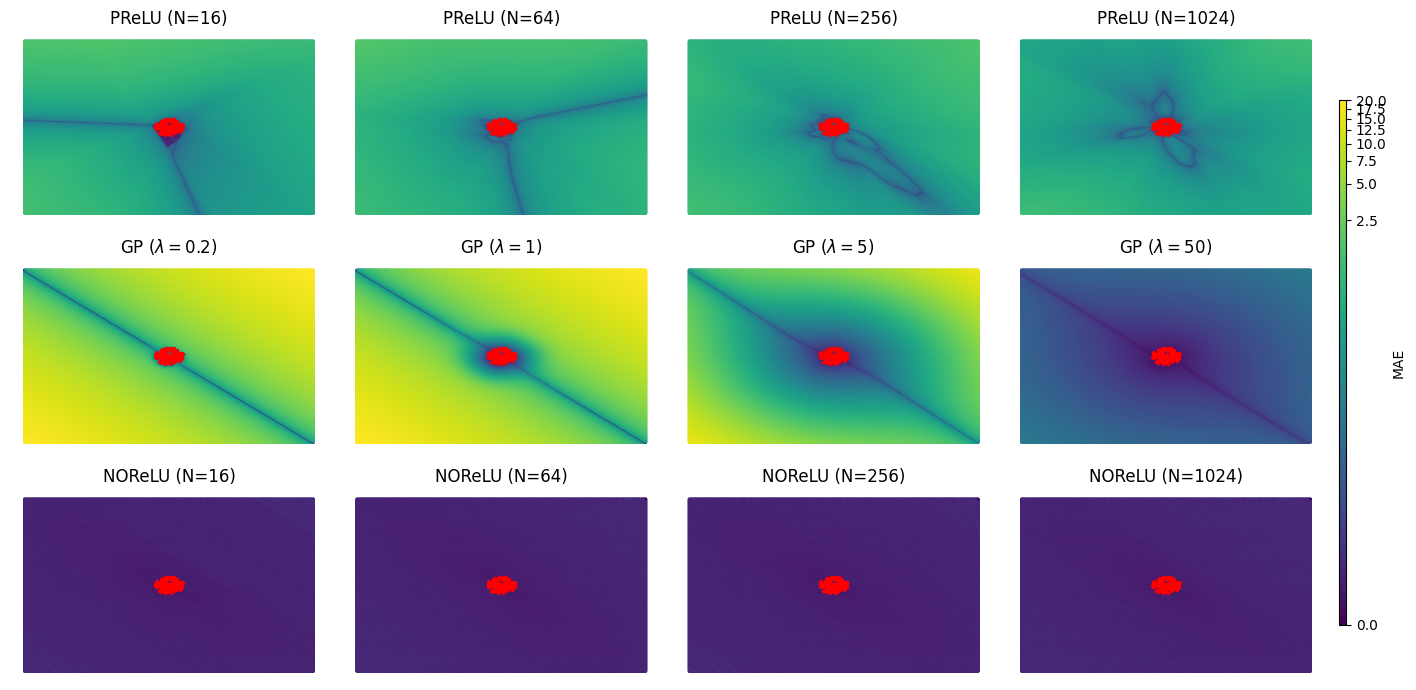

In [18]:
fig = plt.figure(figsize=(14, 7))
num_hiddens = [16, 64, 256, 1024]
length_scales = [.2, 1, 5, 50]


vmin, vmax = 1e9, -1e9


with open(log_dir + 'add_disc_id_results.pkl', 'rb') as handle:
    results = pickle.load(handle)

for i, num_hidden in enumerate(num_hiddens):
  y_ = results['grid_predictions'][i]
  nld = se_dist(y_grid[:, 0], y_)
  vmin = min(nld.min(), vmin)
  vmax = max(nld.max(), vmax)
    
with open(log_dir + 'add_disc_gp_skl_results.pkl', 'rb') as handle:
    results = pickle.load(handle)

for i, num_hidden in enumerate(num_hiddens):
  y_ = results['grid_predictions'][i]
  nld = se_dist(y_grid[:, 0], y_)
  vmin = min(nld.min(), vmin)
  vmax = max(nld.max(), vmax)
        
with open(log_dir + 'add_disc_prelu_results.pkl', 'rb') as handle:
    results = pickle.load(handle)

for i, num_hidden in enumerate(num_hiddens):
  y_ = results['grid_predictions'][i]
  nld = se_dist(y_grid[:, 0], y_)
  vmin = min(nld.min(), vmin)
  vmax = max(nld.max(), vmax)
    
print('vmin vmax', vmin, vmax)

#norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
norm = matplotlib.colors.PowerNorm(gamma=1./8., vmin=vmin, vmax=vmax)

with open(log_dir + 'add_disc_prelu_results.pkl', 'rb') as handle:
    results = pickle.load(handle)
for i, num_hidden in enumerate(num_hiddens):
  plt.subplot(3, 4, 1 + i)
  y_ = results['grid_predictions'][i]
  nld = se_dist(y_grid[:, 0], y_)
  im = plt.scatter(*x_grid.T, c=nld, s=1, norm=norm)
  #plt.colorbar(label='accuracy [neg. log dist.]')  # individual colorbars
  plt.scatter(*data.get_train()[0].T, color='red', s=2)
  plt.title("PReLU (N=%s)" % num_hidden)
  plt.axis('off')

### Bottom row: GP
with open(log_dir + 'add_disc_gp_skl_results.pkl', 'rb') as handle:
    results = pickle.load(handle)
for i, length_scale in enumerate(length_scales[::1]):
  plt.subplot(3, 4, 1 + i + 4)
  y_ = results['grid_predictions'][::1][i]
  nld = se_dist(y_grid[:, 0], y_)
  im = plt.scatter(*x_grid.T, c=nld, s=1, norm=norm)
  #plt.colorbar(label='accuracy [neg. log dist.]')  # individual colorbars
  plt.scatter(*data.get_train()[0].T, color='red', s=2)
  plt.title(r"GP ($\lambda=%s$)" % length_scale)
  plt.axis('off')

### Bottomest row: Identity 'nonlinearity'
with open(log_dir + 'add_disc_id_results.pkl', 'rb') as handle:
    results = pickle.load(handle)
for i, num_hidden in enumerate(num_hiddens):
  plt.subplot(3, 4, 1 + i + 8)
  y_ = results['grid_predictions'][i]
  nld = se_dist(y_grid[:, 0], y_)
  im = plt.scatter(*x_grid.T, c=nld, s=1, norm=norm)
  #plt.colorbar(label='accuracy [neg. log dist.]')  # individual colorbars
  plt.scatter(*data.get_train()[0].T, color='red', s=2)
  plt.title("NOReLU (N=%s)" % num_hidden)
  plt.axis('off')
    
plt.tight_layout()
fig = plt.gcf()
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.1, 0.005, 0.75])
fig.colorbar(im, cax=cbar_ax, label='MAE')
plt.savefig(log_dir + 'fig1.png', dpi=500)
plt.show()

vmin vmax 0.0 0.015704482793807983


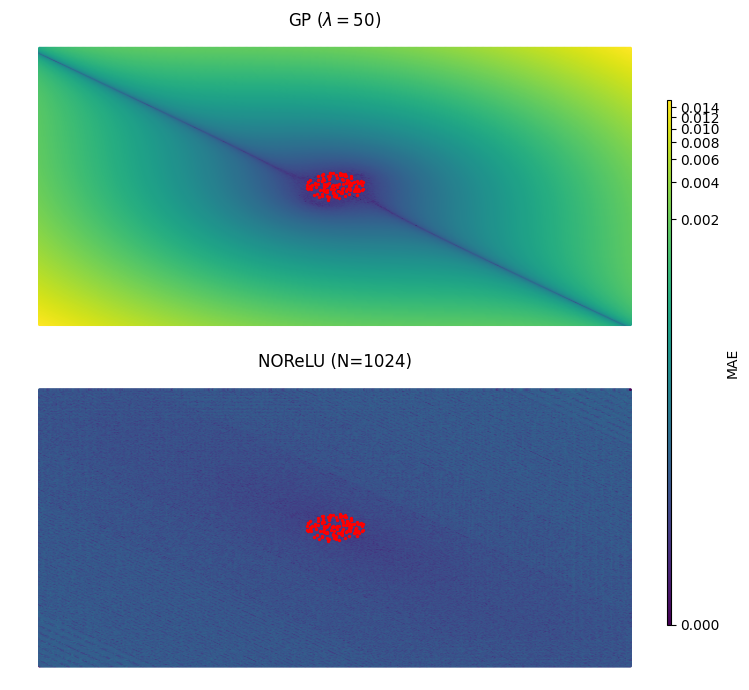

In [19]:
fig = plt.figure(figsize=(7, 7))
num_hiddens = [1024]
length_scales = [50]


vmin, vmax = 1e9, -1e9


with open(log_dir + 'add_disc_id_results.pkl', 'rb') as handle:
    results = pickle.load(handle)

for i, num_hidden in enumerate(num_hiddens):
  y_ = results['grid_predictions'][i+3]
  nld = se_dist(y_grid[:, 0], y_)
  vmin = min(nld.min(), vmin)
  vmax = max(nld.max(), vmax)
    
with open(log_dir + 'add_disc_gp_skl_results.pkl', 'rb') as handle:
    results = pickle.load(handle)

for i, num_hidden in enumerate(num_hiddens):
  y_ = results['grid_predictions'][i+3]
  nld = se_dist(y_grid[:, 0], y_)
  vmin = min(nld.min(), vmin)
  vmax = max(nld.max(), vmax)
print('vmin vmax', vmin, vmax)

#norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
norm = matplotlib.colors.PowerNorm(gamma=1./8., vmin=vmin, vmax=vmax)


### Bottom row: GP
with open(log_dir + 'add_disc_gp_skl_results.pkl', 'rb') as handle:
    results = pickle.load(handle)
for i, length_scale in enumerate(length_scales[::1]):
  plt.subplot(2, 1, 1 + i)
  y_ = results['grid_predictions'][::1][i+3]
  nld = se_dist(y_grid[:, 0], y_)
  im = plt.scatter(*x_grid.T, c=nld, s=1, norm=norm)
  #plt.colorbar(label='accuracy [neg. log dist.]')  # individual colorbars
  plt.scatter(*data.get_train()[0].T, color='red', s=2)
  plt.title(r"GP ($\lambda=%s$)" % length_scale)
  plt.axis('off')

### Bottomest row: Identity 'nonlinearity'
with open(log_dir + 'add_disc_id_results.pkl', 'rb') as handle:
    results = pickle.load(handle)
for i, num_hidden in enumerate(num_hiddens):
  plt.subplot(2, 1, 1 + i + 1)
  y_ = results['grid_predictions'][i+3]
  nld = se_dist(y_grid[:, 0], y_)
  im = plt.scatter(*x_grid.T, c=nld, s=1, norm=norm)
  #plt.colorbar(label='accuracy [neg. log dist.]')  # individual colorbars
  plt.scatter(*data.get_train()[0].T, color='red', s=2)
  plt.title("NOReLU (N=%s)" % num_hidden)
  plt.axis('off')
    
plt.tight_layout()
fig = plt.gcf()
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.1, 0.005, 0.75])
fig.colorbar(im, cax=cbar_ax, label='MAE')
plt.savefig(log_dir + 'fig1.png', dpi=500)
plt.show()